In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import figure
import matplotlib.gridspec as gridspec
from ansim_dataset_unconf import ansimDataset, create_circular_mask, ansimDataset_orientation
from ConvLSTM_unconf import MtConvLSTM
import random
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import os
import scipy.ndimage
import cv2
import scipy.misc
from array2gif import write_gif
from scipy.misc import imsave

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
img_path = '/home/rliu/ansim/data/unconfined_steph/cropped_orientation/'
img_list_csv = '/home/rliu/github/ansim/unconfined_orientation/img_list.csv'
train_csv = '/home/rliu/github/ansim/unconfined_orientation/train_unconf.csv'
test_csv = '/home/rliu/github/ansim/unconfined_orientation/test_unconf.csv'
# output_path = '/home/rliu/ansim/models/dataset3/6-17_mt_paper_orientation/final.weights'

img_path_r = '/home/rliu/ansim/data/unconfined_steph/cropped_retardance/'
img_list_csv = '/home/rliu/github/ansim/unconfined_orientation/img_list.csv'
train_csv = '/home/rliu/github/ansim/unconfined_orientation/train_unconf.csv'
test_csv = '/home/rliu/github/ansim/unconfined_orientation/test_unconf.csv'
# output_path_o = '/home/rliu/ansim/models/dataset3/6-17_mt_paper_retardance/final.weights'

In [4]:
mask = create_circular_mask(128,128)
orientation_set = ansimDataset_orientation(img_list_csv = img_list_csv, seq_csv = test_csv, root_dir = img_path, step=10, random_rotate = False, transform=None, image_size = 128, rand_range=0)
orientation_loader = torch.utils.data.DataLoader(orientation_set, batch_size=1, shuffle=False,
                                                     num_workers=1)

retardance_set = ansimDataset(img_list_csv = img_list_csv, seq_csv = test_csv, root_dir = img_path_r, step=10, random_rotate = False, transform=None, image_size = 128, rand_range=0)
retardance_loader = torch.utils.data.DataLoader(retardance_set, batch_size=1, shuffle=False,
                                                     num_workers=1)

In [5]:
model = torch.load('/home/rliu/ansim/models/dataset3/6-19_mt_paper_orientation/0220.weights')
model = model.module

/home/rliu/.local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rliu/.local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rliu/.local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the 

In [33]:
dataiter = iter(orientation_loader)
for i in range(6):
    images = dataiter.next()
    data_split = torch.split(images, (5,5), dim=1)
    inputs_t = data_split[0]
    target_t = data_split[1]
    inputs_t, target_t = inputs_t.cuda(), target_t.cuda()
_, _, _, predicted_t = model(inputs_t)

dataiter = iter(retardance_loader)
for i in range(6):
    images_r = dataiter.next()
    data_split_r = torch.split(images_r, (5,5), dim=1)
    inputs_t_r = data_split_r[0]
    target_t_r = data_split_r[1]
    inputs_t_r, target_t_r = inputs_t_r.cuda(), target_t_r.cuda()

In [35]:
predicted = predicted_t[0,:,:,:,:].cpu().detach().numpy()
target = target_t[0,:,:,:,:].cpu().detach().numpy()
inputs = inputs_t[0,:,:,:,:].cpu().detach().numpy()

target_r = target_t_r[0,:,:,:,:].cpu().detach().numpy()
inputs_r = inputs_t_r[0,:,:,:,:].cpu().detach().numpy()

In [36]:
predicted_gf = np.zeros(predicted.shape)
target_gf = np.zeros(target.shape)
inputs_gf = np.zeros(inputs.shape)

In [37]:
inputs_gf[:,0,:,:] = np.sqrt(inputs[:,0,:,:] + 1/2)
inputs_gf[:,1,:,:] = inputs[:,1,:,:] / inputs_gf[:,0,:,:]

target_gf[:,0,:,:] = np.sqrt(target[:,0,:,:] + 1/2)
target_gf[:,1,:,:] = target[:,1,:,:] / target_gf[:,0,:,:]

predicted_gf[:,0,:,:] = np.sqrt(predicted[:,0,:,:] + 1/2)
predicted_gf[:,1,:,:] = predicted[:,1,:,:] / predicted_gf[:,0,:,:]

/home/rliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


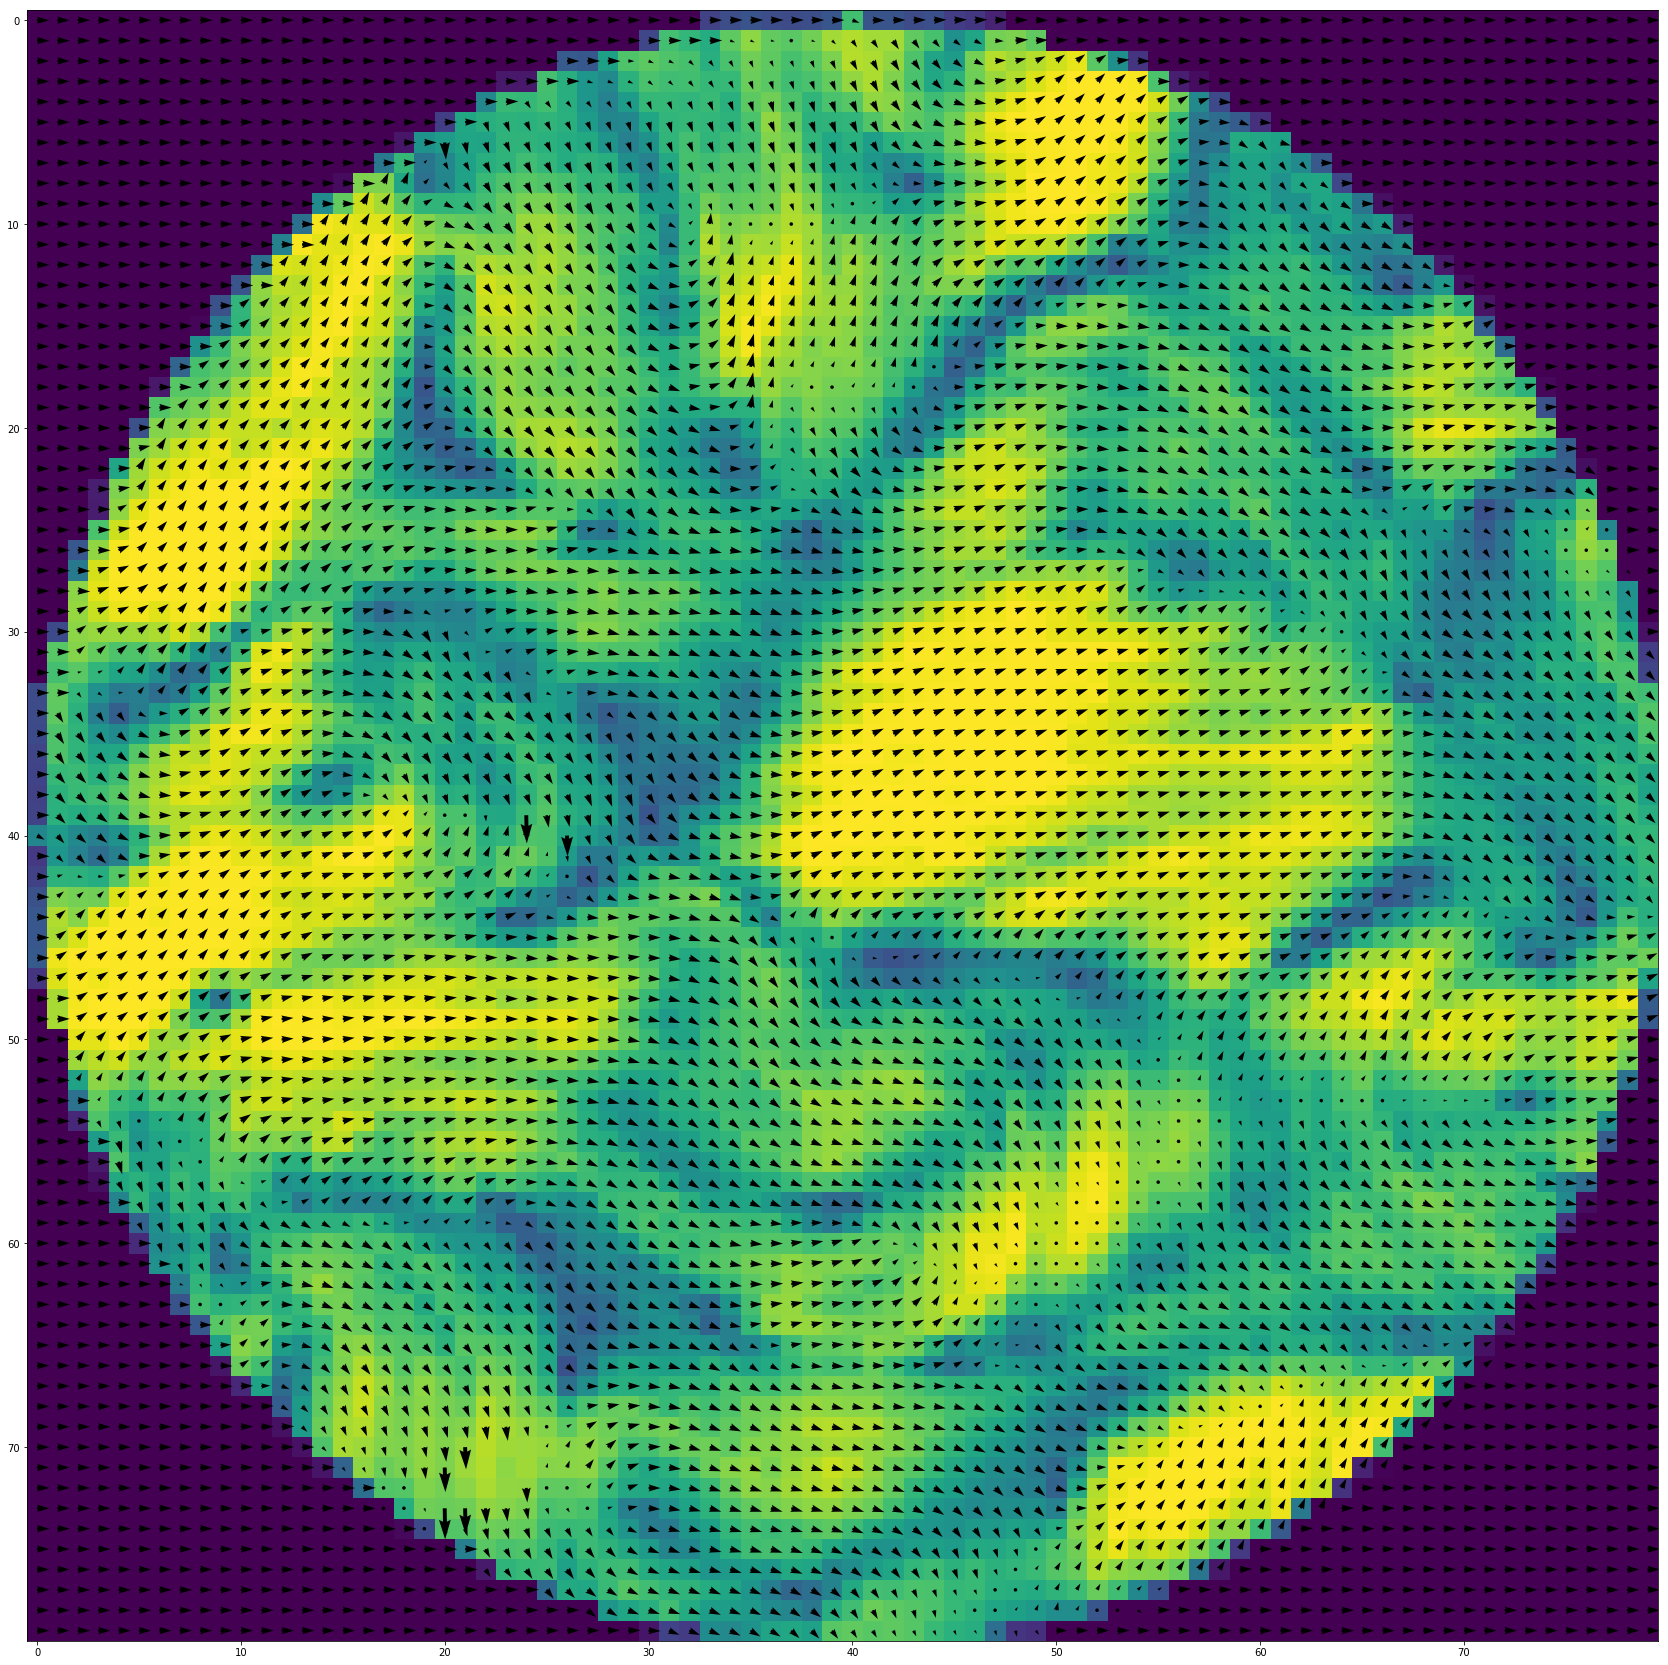

In [53]:
index = 3
img = target_r[index,0,:,:]
size = 80
img = cv2.resize(img, (size,size),interpolation=cv2.INTER_LINEAR)
U = predicted_gf[index,0,:,:]
U = cv2.resize(U,(size,size),interpolation=cv2.INTER_NEAREST)
V = predicted_gf[index,1,:,:]
V = cv2.resize(V,(size,size),interpolation=cv2.INTER_NEAREST)
X, Y = np.meshgrid(np.arange(size), np.arange(size))
fig = plt.figure(figsize=(30, 30))
# gs = gridspec.GridSpec(nrows=10, ncols=10, height_ratios=[1, 1, 1])
# ax0 = fig.add_subplot()
plt.imshow(img)
plt.quiver(X, Y, U, V, cmap='autumn')
# color = 2 * np.log(np.hypot(U,V))
# plt.streamplot(X,Y,U,V, color=color, linewidth=1, cmap=plt.cm.inferno,
#               density=2, arrowstyle='->', arrowsize=1.5)

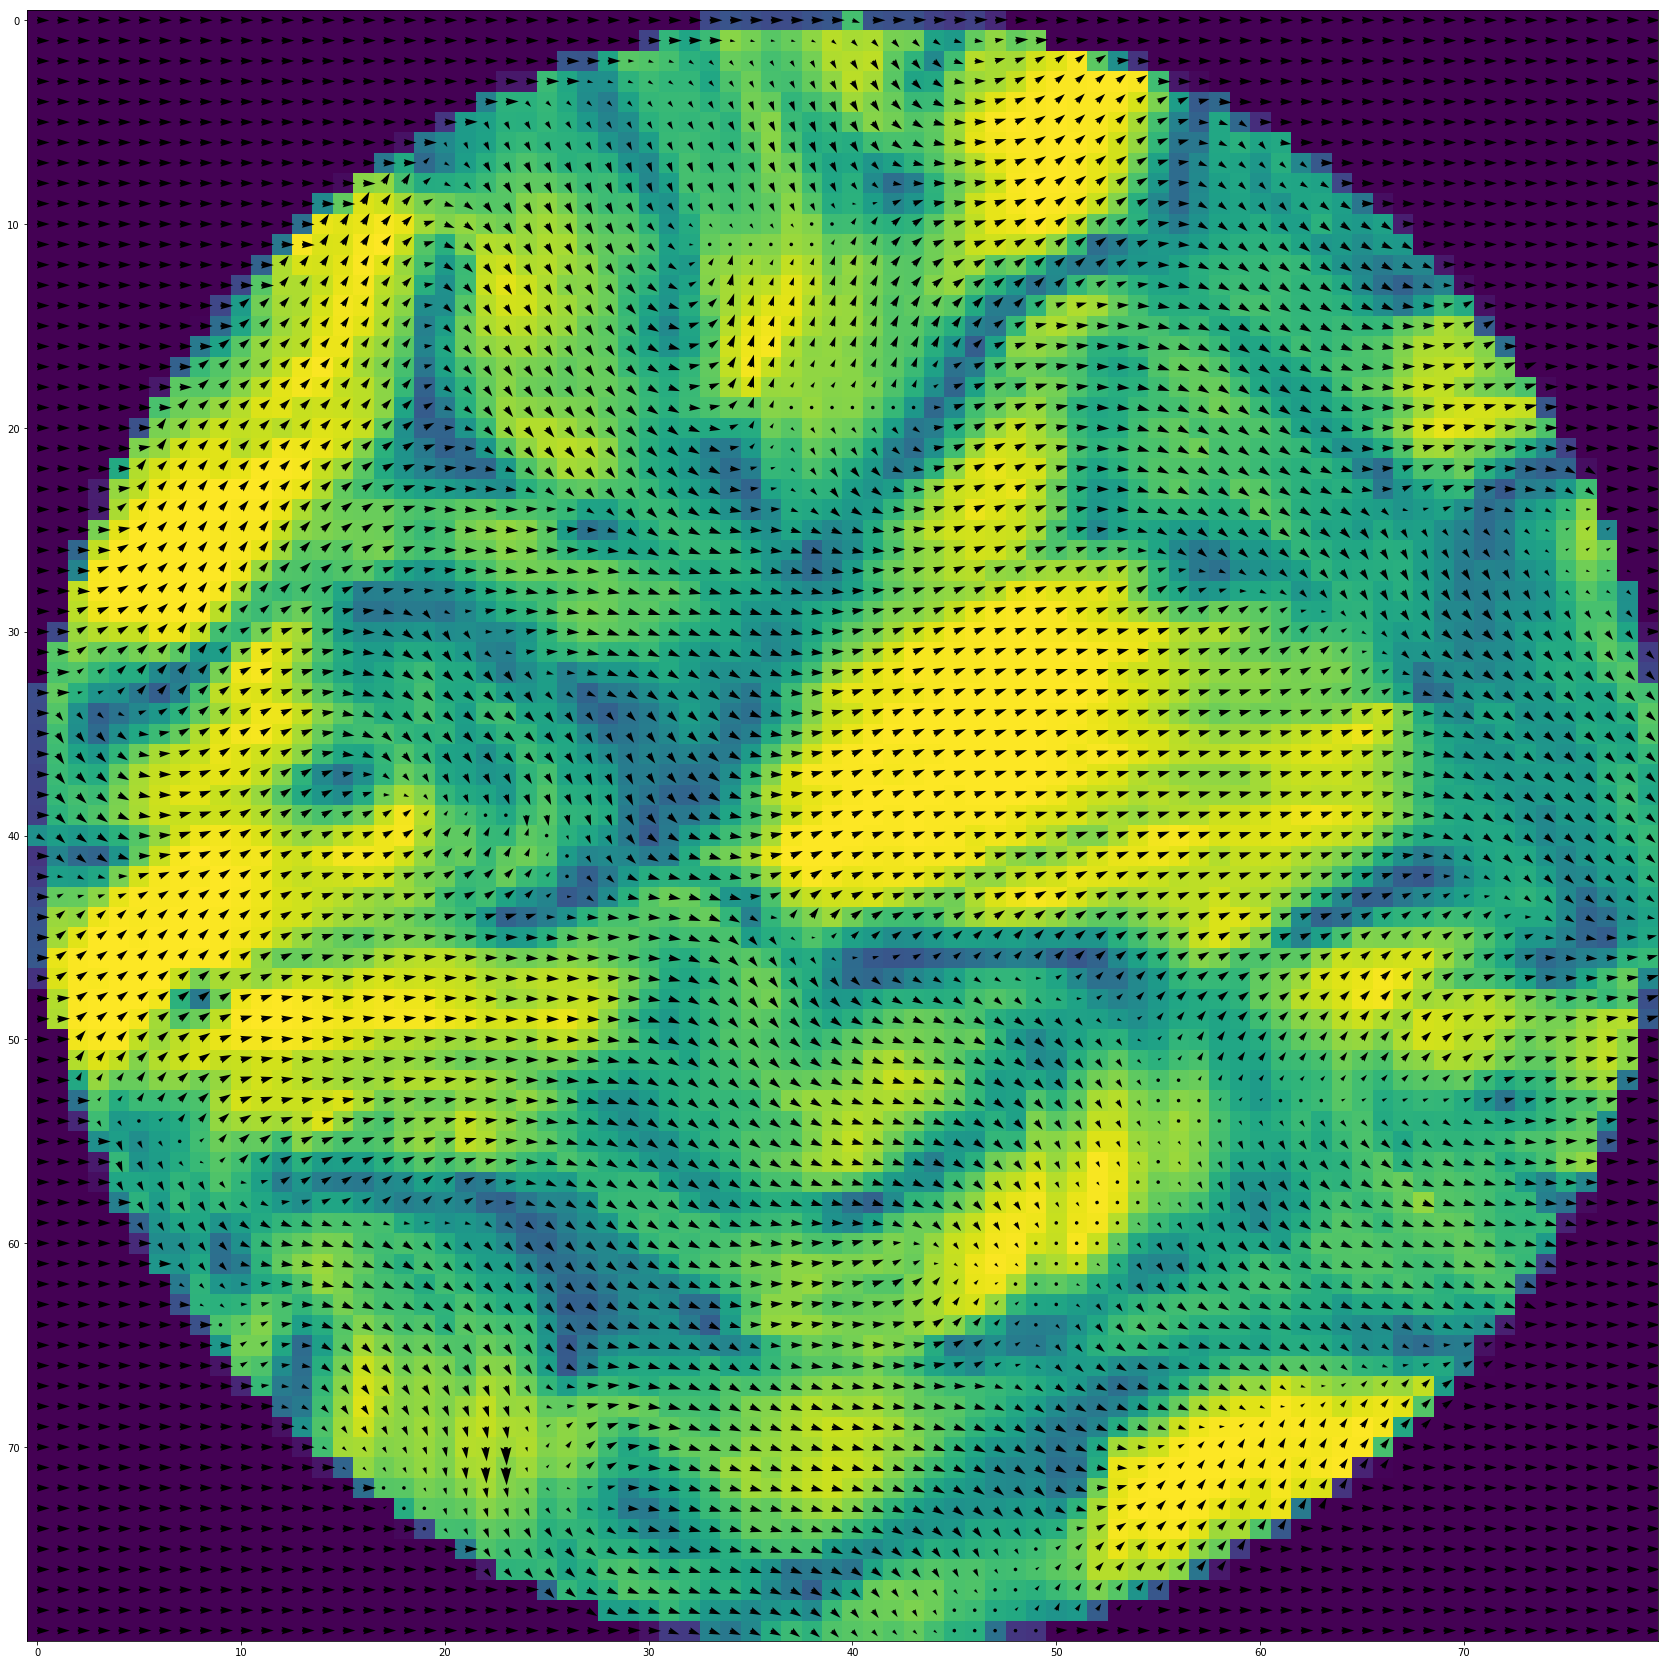

In [50]:
index = 4
img = target_r[index,0,:,:]
size = 80
img = cv2.resize(img, (size,size),interpolation=cv2.INTER_LINEAR)
U = predicted_gf[index,0,:,:]
U = cv2.resize(U,(size,size),interpolation=cv2.INTER_NEAREST)
V = predicted_gf[index,1,:,:]
V = cv2.resize(V,(size,size),interpolation=cv2.INTER_NEAREST)
X, Y = np.meshgrid(np.arange(size), np.arange(size))
fig = plt.figure(figsize=(30, 30))
# gs = gridspec.GridSpec(nrows=10, ncols=10, height_ratios=[1, 1, 1])
# ax0 = fig.add_subplot()
plt.imshow(img)
plt.quiver(X, Y, U, V, cmap='autumn')
# color = 2 * np.log(np.hypot(U,V))
# plt.streamplot(X,Y,U,V, color=color, linewidth=1, cmap=plt.cm.inferno,
#               density=2, arrowstyle='->', arrowsize=1.5)

In [15]:
print(np.min(inputs), np.max(inputs))
print(np.min(target), np.max(target))
print(np.min(predicted), np.max(predicted))

print(np.min(inputs_gf), np.max(inputs_gf))
print(np.min(target_gf), np.max(target_gf))
print(np.min(predicted_gf), np.max(predicted_gf))

0 254
0 254
0 283
-1.000067814616159 1.000067814616159
-1.000067814616159 1.000067814616159
nan nan


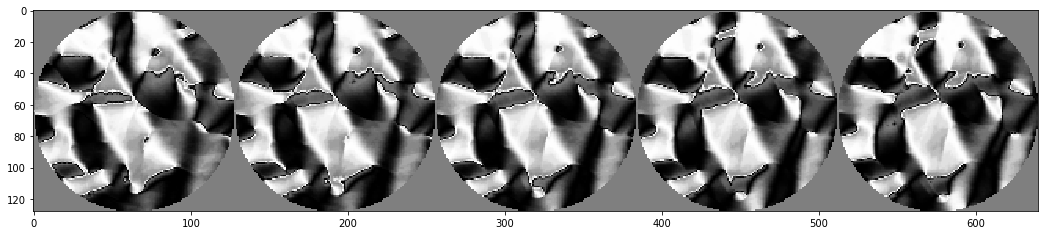

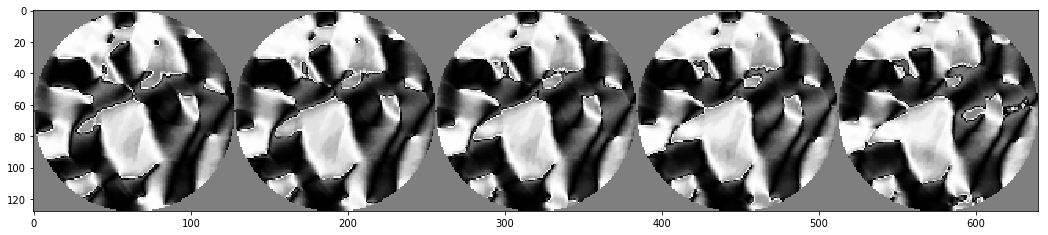

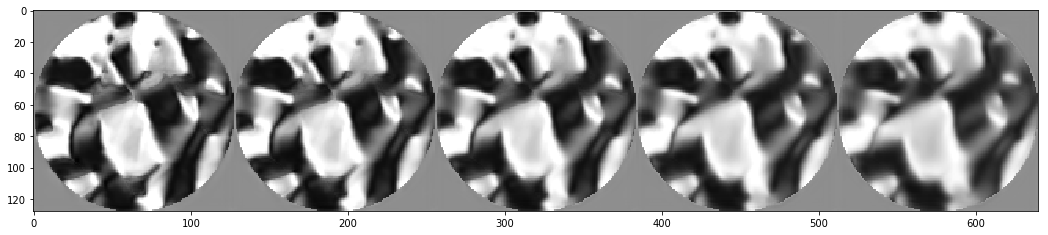

In [12]:
inputs = inputs_t[0,:,1,:,:].cpu().detach().numpy()
target = target_t[0,:,1,:,:].cpu().detach().numpy()
predicted = predicted_t[0,:,1,:,:].cpu().detach().numpy()

inputs = (inputs + 0.5) * 255
target = (target + 0.5) * 255
predicted = (predicted + 0.5) * 255

inputs = inputs.reshape(640,128).transpose().astype(int)
target = target.reshape(640,128).transpose().astype(int)
predicted = predicted.reshape(640,128).transpose().astype(int)

inputs = inputs - inputs.min()
target = target - target.min()
predicted = predicted - predicted.min()

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(inputs, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(target, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(predicted, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

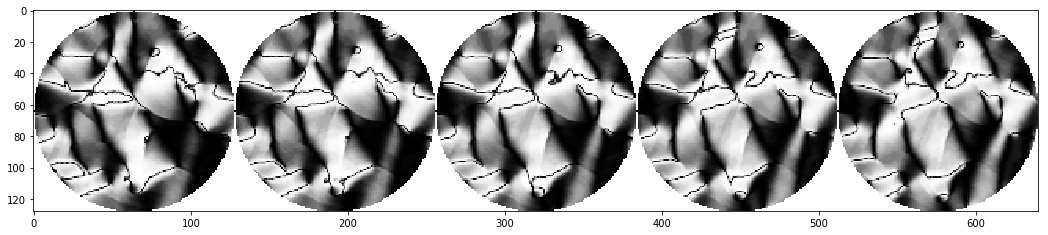

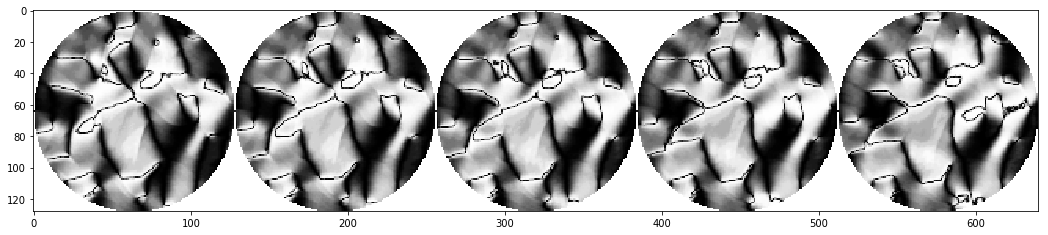

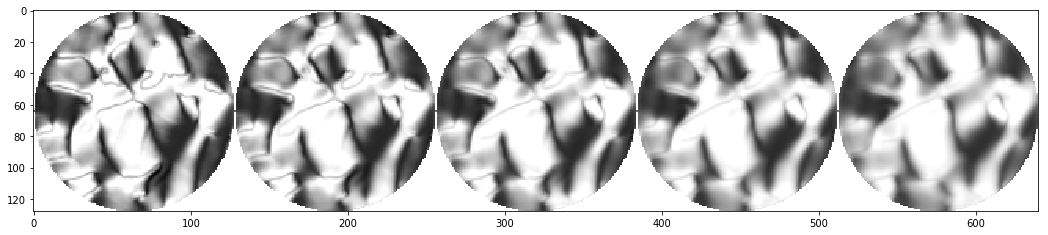

In [92]:
predicted = predicted_t[0,:,0,:,:].cpu().detach().numpy()
target = target_t[0,:,0,:,:].cpu().detach().numpy()
inputs = inputs_t[0,:,0,:,:].cpu().detach().numpy()

inputs = (inputs + 0.5) * 255
target = (target + 0.5) * 255
predicted = (predicted + 0.5) * 255

inputs = inputs.reshape(640,128).transpose().astype(int)
target = target.reshape(640,128).transpose().astype(int)
predicted = predicted.reshape(640,128).transpose().astype(int)

inputs = inputs - inputs.min()
target = target - target.min()
predicted = predicted - predicted.min()

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(inputs, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(target, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(predicted, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

In [19]:
predicted_t.shape

torch.Size([1, 10, 1, 128, 128])

In [8]:
imsave('gradient.png', inputs[0,:,:])

NameError: name 'inputs' is not defined

In [15]:
predicted = predicted_t[0,:,0,:,:].cpu().detach().numpy()
target = target_t[0,:,0,:,:].cpu().detach().numpy()
inputs = inputs_t[0,:,0,:,:].cpu().detach().numpy()

inputs = inputs.reshape(1280,128).transpose().astype(int)
target = target.reshape(2560,128).transpose().astype(int)
predicted = predicted.reshape(2560,128).transpose().astype(int)

inputs = inputs - inputs.min()
target = target - target.min()
predicted = predicted - predicted.min()

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(inputs, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(target, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(predicted, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

# plt.savefig('/home/rliu/ansim/results/inputs.jpg')

ValueError: cannot reshape array of size 163840 into shape (2560,128)

In [18]:
predicted = predicted_t[0,:,0,:,:].cpu().detach().numpy()

target = target_t[0,:,0,:,:].cpu().detach().numpy()
inputs = inputs_t[0,:,0,:,:].cpu().detach().numpy()
write_gif(inputs, 'rgbbgr.gif', fps=3)

ValueError: The dataset's first dimension must have all 3
colors: red, green, and blue...in that order.

In [ ]:
predicted = predicted_t[0,:,0,:,:].cpu().detach().numpy().astype(int)
target = target_t[0,:,0,:,:].cpu().detach().numpy().astype(int)
inputs = inputs_t[0,:,0,:,:].cpu().detach().numpy().astype(int)
inputs = inputs - inputs.min()
target = target - target.min()
predicted = predicted - predicted.min()

In [ ]:
for i in range(10):
    output_path = '/home/rliu/ansim/results/4-20_18-3x3/t163/input%0.2d.jpg' % (i+1)
    plt.imshow(inputs[i],cmap = 'gray')
    plt.savefig(output_path)
    
for i in range(10):
    output_path = '/home/rliu/ansim/results/4-20_18-3x3/t163/target%0.2d.jpg' % (i+1)
    plt.imshow(target[i],cmap = 'gray')
    plt.savefig(output_path)
    
for i in range(10):
    output_path = '/home/rliu/ansim/results/4-20_18-3x3/t163/predicted%0.2d.jpg' % (i+1)
    plt.imshow(predicted[i],cmap = 'gray')
    plt.savefig(output_path)



In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
img_path = '/home/rliu/ansim/data/data/JPEGImages/'
img_list_csv = '/home/rliu/github/ansim/img_list.csv'
train_csv = '/home/rliu/github/ansim/d200um/train200.csv'
test_csv = '/home/rliu/github/ansim/d200um/test200.csv'
output_path = '/home/rliu/ansim/models/dataset2/4-25_mt-6-8-10-15/0235.weights'

In [4]:
mask = create_circular_mask(128,128)

testset = ansimDataset(img_list_csv = img_list_csv, seq_csv = test_csv, root_dir = img_path, step=20, random_rotate = False, transform=None, image_size = 128, rand_range=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False,
                                                     num_workers=1)

In [5]:
model = torch.load('/home/rliu/ansim/models/dataset2/4-25_mt-6-8-10-15/0235.weights').cuda()

In [ ]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU in use")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()
with torch.no_grad():
    running_loss_test = 0.0
    loss_by_class = 0.0
    test_iter = 0
    for data in testloader:
        test_iter += 1
        data_split = torch.split(data, int(data.shape[1]/2), dim=1)
        inputs = data_split[0]
        target = data_split[1]


        if use_gpu:
            inputs, target = inputs.to(device), target.to(device)
        else:
            inputs, target = Variable(inputs), Variable(target)


        _, _, _, predicted = model(inputs)


        loss_test = criterion(predicted, target)
        iter_loss_test = loss_test.item()
        running_loss_test += loss_test.item()    
        epoch_loss_test = running_loss_test / len(testset)
        loss_by_class += loss_test.item()
        if test_iter == 21:
            print('Loss on the 1-21: %.5f ' % (loss_by_class/21.0))
            loss_by_class = 0.0
        elif test_iter == 31:
            print('Loss on the 22-31: %.5f ' % (loss_by_class/10.0))
            loss_by_class = 0.0
        elif test_iter == 111:
            print('Loss on the 32-111: %.5f ' % (loss_by_class/80.0))
            loss_by_class = 0.0
        elif test_iter == 257:
            print('Loss on the 112-257: %.5f ' % (loss_by_class/146.0))
            loss_by_class = 0.0
        epoch_loss_test = running_loss_test / len(testset)

    print('Loss on the test images: %.5f ' % (epoch_loss_test))

GPU in use


/home/rliu/.local/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Loss on the 1-21: 113.84817 
Loss on the 22-31: 202.21560 


In [7]:
dataiter = iter(testloader)
for i in range(100):
    images = dataiter.next()
data_split = torch.split(images, int(images.shape[1]/2), dim=1)
inputs_t = data_split[0]
target_t = data_split[1]

inputs_t, target_t = inputs_t.cuda(), target_t.cuda()

_, _, _, predicted_t = model(inputs_t)

NameError: name 'testloader' is not defined

In [ ]:
predicted = predicted_t[0,:,0,:,:].cpu().detach().numpy()

target = target_t[0,:,0,:,:].cpu().detach().numpy()

inputs = inputs_t[0,:,0,:,:].cpu().detach().numpy()

inputs = inputs.reshape(1280,128).transpose().astype(int)
target = target.reshape(1280,128).transpose().astype(int)
predicted = predicted.reshape(1280,128).transpose().astype(int)

inputs = inputs - inputs.min()
target = target - target.min()
predicted = predicted - predicted.min()

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(inputs, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(target, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(predicted, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

# plt.savefig('/home/rliu/ansim/results/inputs.jpg')

In [23]:
'/home/rliu/ansim/results/input%0.2d.jpg' % 5

'/home/rliu/ansim/results/input05.jpg'

In [1]:
scipy.misc.imsave('1.jpg', predicted[0])

NameError: name 'scipy' is not defined

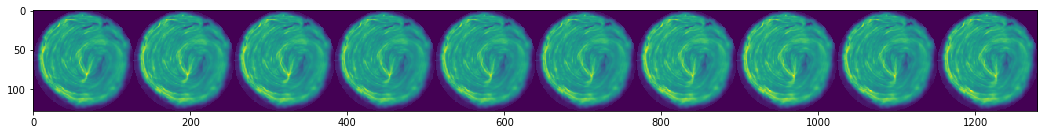

In [62]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(inputs, interpolation='nearest',shape=(128,1280))
plt.savefig('/home/rliu/ansim/models/inputs.jpg')

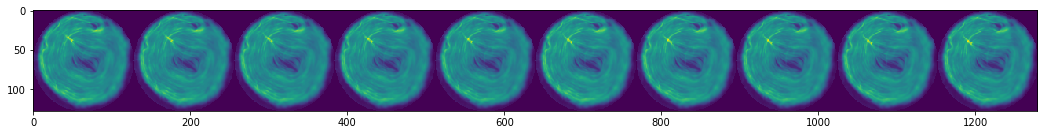

In [55]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(target, interpolation='nearest',shape=(128,1280))
plt.savefig('/home/rliu/ansim/models/target.jpg')

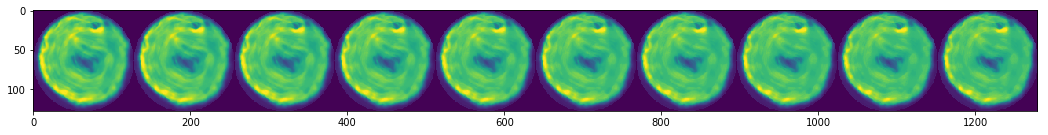

In [57]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(predicted, interpolation='nearest',shape=(128,1280))
plt.savefig('/home/rliu/ansim/models/predicted.jpg')

In [ ]:
np.transpose(predicted,(1,2,0))

In [1]:
import numpy as np
from PIL import Image

# gradient between 0 and 1 for 256*256
array = np.linspace(0,1,256*256)

# reshape to 2d
mat = np.reshape(array,(256,256))

# Creates PIL image
img = Image.fromarray( mat , 'L')
img.show()

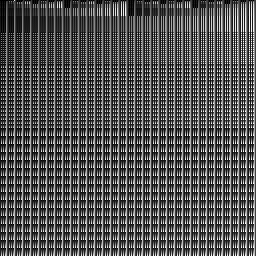

In [2]:
img